In [0]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import Attention
from keras.models import Model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [0]:
BATCH_SIZE=70
EPOCHS=80
latent_dim=128
embedding_dim=128
test_train_split=0.35
build_number="2"
# LEARNING_RATE=0.0001

In [0]:
df = pd.read_csv('./data0.csv')
df.head(1)

,Unnamed: 0,file,text,summary
0,0,0002c17436637c4fe1837c935c04de47adb18e9a.story,Los Angeles A medical doctor Vancouver British...,NEW A Canadian doctor says part team examining...


In [0]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\..*$',' ',str(x)))
print(df['summary'][0])

NEW A Canadian doctor says part team examining Harry Burkhart 2010 NEW Diagnosis autism severe anxiety posttraumatic stress disorder depression Burkhart also suspected German arson probe officials say Prosecutors believe German national set string fires Los Angeles
NEW A Canadian doctor says part team examining Harry Burkhart 2010 NEW Diagnosis autism severe anxiety posttraumatic stress disorder depression Burkhart also suspected German arson probe officials say Prosecutors believe German national set string fires Los Angeles


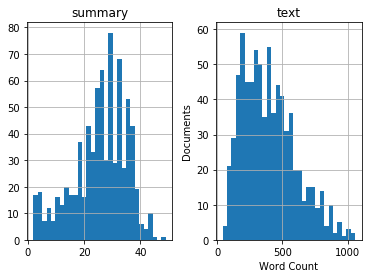

In [0]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

In [0]:
cnt=0
for i in df['summary']:
    if(len(i.split())<=50):
        cnt=cnt+1
print(cnt/len(df['summary']))

1.0


In [0]:
cnt=0
for i in df['text']:
    if(len(i.split())<=800):
        cnt=cnt+1
print(cnt/len(df['text']))

0.9541284403669725


In [0]:
max_text_len = max([len(txt) for txt in df['text']])
max_summary_len = max([len(txt) for txt in df['summary']])
print(max_text_len)
print(max_summary_len)

7301
330


In [0]:
X = np.array(df['text'])
Y = np.array(df['summary'])

In [0]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=test_train_split,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(495,)
(268,)
(495,)
(268,)


In [0]:
#prepare a tokenizer for reviews on training data
# x_tokenizer = Tokenizer() 
# x_tokenizer.fit_on_texts(list(X))

In [0]:
# thresh=10

# cnt=0
# tot_cnt=0
# freq=0
# tot_freq=0
# 
# for key,value in x_tokenizer.word_counts.items():
#     tot_cnt=tot_cnt+1
#     tot_freq=tot_freq+value
#     if(value<thresh):
#         cnt=cnt+1
#         freq=freq+value
    
# print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
# print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [0]:
word_dict = {}
text = df['text']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

In [0]:
# #prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=len(word_dict)) 
x_tokenizer.fit_on_texts(list(X))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

29712


In [0]:
#prepare a tokenizer for reviews on training data
# y_tokenizer = Tokenizer()   
# y_tokenizer.fit_on_texts(list(Y))

In [0]:
# thresh=30

# cnt=0
# tot_cnt=0
# freq=0
# tot_freq=0

# for key,value in y_tokenizer.word_counts.items():
#     tot_cnt=tot_cnt+1
#     tot_freq=tot_freq+value
#     if(value<thresh):
#         cnt=cnt+1
#         freq=freq+value
    
# print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
# print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [0]:
word_dict = {}
text = df['summary']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=len(word_dict)) 
y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print(y_voc)

8004


In [0]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))
#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#encoder lstm 
encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
                                                          
#dense layer
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 7301)         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 7301, 128)    3803136     input_12[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 128)    1024512     input_13[0][0]                   
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=4, restore_best_weights=False)

In [0]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 495 samples, validate on 268 samples
Epoch 1/80
495/495 [==============================] - 129s 260ms/step - loss: 7.7796 - val_loss: 4.1837
Epoch 2/80
495/495 [==============================] - 126s 254ms/step - loss: 2.8477 - val_loss: 1.5067
Epoch 3/80
495/495 [==============================] - 128s 259ms/step - loss: 1.2713 - val_loss: 0.9959
Epoch 4/80
495/495 [==============================] - 130s 262ms/step - loss: 0.9206 - val_loss: 0.8197
Epoch 5/80
495/495 [==============================] - 126s 255ms/step - loss: 0.8025 - val_loss: 0.7445
Epoch 6/80
495/495 [==============================] - 125s 253ms/step - loss: 0.7445 - val_loss: 0.7096
Epoch 7/80
495/495 [==============================] - 121s 245ms/step - loss: 0.7119 - val_loss: 0.6855
Epoch 8/80
495/495 [==============================] - 121s 244ms/step - loss: 0.6819 - val_loss: 0.6743
Epoch 9/80
495/495 [==============================] - 121s 244ms/step - loss: 0.6690 - val_loss: 0.6642
Epoch 10/80
495/49

In [0]:
model.save('model' + str(build_number) + '.h5')

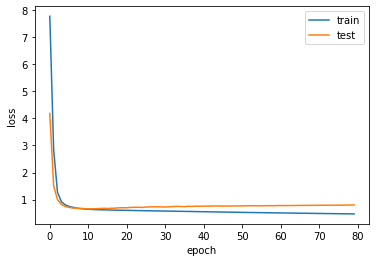

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss' + str(build_number) + '.png')
plt.show()

## Inference Model

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
encoder_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 7301)              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 7301, 128)         3803136   
_________________________________________________________________
lstm_9 (LSTM)                [(None, 7301, 128), (None 131584    
Total params: 3,934,720
Trainable params: 3,934,720
Non-trainable params: 0
_________________________________________________________________


In [0]:
decoder_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 128)    1024512     input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 128)          0                                            
____________________________________________________________________________________________

In [0]:
model.save('encoder_model' + str(build_number) + '.h5')
model.save('decoder_model' + str(build_number) + '.h5')

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, max_summary_len))
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
      print(output_tokens)
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      print(sampled_token_index)
      # print(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+sampled_token
      else :
        stop_condition = True
      if (len(decoded_sentence.split()) >= (max_summary_len-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      # target_seq = np.zeros((1,1))
      target_seq = np.zeros((1, max_summary_len))
      target_seq[0, sampled_token_index] = 1

      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

In [0]:
for i in range(0,5):
    print("Article:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    x_i = x_tr[i].reshape(1,max_text_len)   
    print("Generated summary:",decode_sequence(x_i))
    print("\n")

Article: rome amanda knoxs exboyfriend murder trial codefendant reveal new book sometimes question innocence bizarre behavior day british student found dead apartment raffaele sollecitos memoir honor bound my journey hell back amanda knox first book write anyone directly involve meredith kercher murder trial perugia italy kercher 21yearold british student found stabbed death italian apartment share knox 25 seattle sollecito knox convict kerchers murder 2009 set free appeal 2011 they face final highcourt decision march judge explains murder acquittal italian prosecutor appeal decision rudy guede ivory coast convict separately 2008 his conviction upheld appeal 2009 sollecitos book draw heavily diary kept letter write friend family hometown newspaper year prison preface say he chronicle day murder admit knox smoke marijuana afternoon say regret cloud memory happen while maintain innocence say clearly remember even knox spent night he knox make mistake morning discovery include trust polic

In [0]:
import pickle
with open('xtokenizer.pickle', 'wb') as handle:
  pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ytokenizer.pickle', 'wb') as handle:
  pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)